In [ ]:
from zipfile import ZipFile

import numpy as np
import matplotlib.pyplot as plt
import os

# pandas to open data files & processing it.
import pandas as pd
# to see all columns
pd.set_option('display.max_columns', None)
# To see whole text
pd.set_option('max_colwidth', None)

import logging
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# keras for deep learning model creation
from keras.preprocessing.text import Tokenizer

import re
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split

from keras.utils import to_categorical
from keras import models
from keras import layers

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Flatten, TimeDistributed, Bidirectional, Dropout

In [ ]:
from google.colab import drive
drive.mount('/content/grive')

Mounted at /content/grive


In [ ]:
!pwd

/content/grive/MyDrive/Colab Notebooks/NLP 2 Data


In [ ]:
# Read in the data as a dataframe and analyse it

headline_df_1 = pd.read_json("Sarcasm_Headlines_Dataset.json", lines=True)

print(headline_df_1.shape)
headline_df_1.head()


(26709, 3)


,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5,former versace store clerk sues over secret 'black code' for minority shoppers,0
1,https://www.huffingtonpost.com/entry/roseanne-revival-review_us_5ab3a497e4b054d118e04365,"the 'roseanne' revival catches up to our thorny political mood, for better and worse",0
2,https://local.theonion.com/mom-starting-to-fear-son-s-web-series-closest-thing-she-1819576697,mom starting to fear son's web series closest thing she will have to grandchild,1
3,https://politics.theonion.com/boehner-just-wants-wife-to-listen-not-come-up-with-alt-1819574302,"boehner just wants wife to listen, not come up with alternative debt-reduction ideas",1
4,https://www.huffingtonpost.com/entry/jk-rowling-wishes-snape-happy-birthday_us_569117c4e4b0cad15e64fdcb,j.k. rowling wishes snape happy birthday in the most magical way,0


In [ ]:
# Drop unwanted column

headline_df_1.drop(['article_link'] , inplace =True , axis = 1)

headline_df_1.isnull().sum()

headline        0
is_sarcastic    0
dtype: int64

In [ ]:
headline_df_1.dtypes

headline        object
is_sarcastic     int64
dtype: object

In [ ]:
headline_df_1['headline'].duplicated().sum()

107

In [ ]:
# Remove duplicates

headline_df_1.duplicated().sum()

107

In [ ]:
headline_df_1[headline_df_1['headline'].duplicated(keep=False)]

,headline,is_sarcastic
182,magic-markered initials fail to deter breakroom rice-cake thief,1
533,antarctic observational comic running out of ideas,1
1019,the best chance to defeat roy moore may be for the democratic party to lie low,0
1091,antarctic observational comic running out of ideas,1
1131,pier 1 issues formal apology for rattan death march,1
...,...,...
26121,"'no way to prevent this,' says only nation where this regularly happens",1
26156,"area man busts his ass all day, and for what?",1
26353,kleenex box inadequately covered,1
26500,candy purchase puts yet more money in raisinets' bloated coffers,1


In [ ]:
headline_df_1 = headline_df_1.drop_duplicates()
print(headline_df_1.shape)

(26602, 2)


In [ ]:
# Text Data Pre-Processing & Cleanup

def split_into_words(text):
  # split into words by white space
  words = text.split()
  return words
  

log = logging.getLogger(__name__)
log.addHandler(logging.NullHandler())

def lowercase(words_list):
  logging.info("Converting list of words to lowercase")
  lowercase = []
  for word in words_list:
    lowercase.append(word.lower())
  return lowercase

def remove_special_characters(words_list):
  log.info("Removing special characters from array of words")
  #no_special_characters = df.replace(r'[^A-Za-z]+',' ', regex=True)
  no_special_characters = [re.sub('[^a-zA-Z0-9]+', '', _) for _ in words_list]
  return no_special_characters


def remove_url(words_str):
  return re.sub('http\S+','', words_str)

stops = set(stopwords.words('english'))

def remove_stopwords(words_str):
  stopwords_removed = " ".join([word for word in words_str.split() if word not in (stops)])
  return stopwords_removed

def remove_whitespace(words_str):
  log.info("Removing extra whitespaces between words")
  # replace more than 1 space with 1 space
  merged_spaces = words_str.replace(r"\s\s+",' ')
  # delete beginning and trailing spaces
  trimmed_spaces = merged_spaces.strip()
  return trimmed_spaces

def to_sentence(words):
  # join words to a sentence
  return ' '.join(words)

def denoise(text):
  words_list = split_into_words(text)
  
  words_list = lowercase(words_list)

  words_list = remove_special_characters(words_list)

  #text = text.to_string()
  words_str = to_sentence(words_list)
  
  words_str = remove_url(words_str)

  words_str = remove_stopwords(words_str)

  words_str = remove_whitespace(words_str)

  return words_str


headline_df_1['cleaned'] = headline_df_1['headline'].apply(denoise)

In [ ]:
headline_df_1['cleaned'].head()

0    former versace store clerk sues secret black code minority shoppers
1            roseanne revival catches thorny political mood better worse
2             mom starting fear sons web series closest thing grandchild
3         boehner wants wife listen come alternative debtreduction ideas
4                     jk rowling wishes snape happy birthday magical way
Name: cleaned, dtype: object

In [ ]:
# Length of Each Sentences

len_sentences = [len(i) for i in headline_df_1['cleaned']]
print("Length of each sentence in the dataframe", len_sentences)

Length of each sentence in the dataframe [67, 59, 58, 62, 50, 22, 37, 33, 50, 48, 56, 52, 61, 39, 45, 50, 74, 46, 49, 20, 46, 88, 50, 18, 53, 27, 55, 21, 50, 26, 47, 35, 51, 51, 58, 18, 33, 63, 54, 64, 56, 66, 51, 46, 29, 41, 78, 58, 31, 29, 27, 40, 62, 52, 68, 53, 57, 37, 58, 51, 24, 18, 40, 80, 59, 50, 50, 47, 41, 35, 27, 37, 30, 44, 61, 44, 52, 54, 29, 48, 51, 59, 57, 64, 47, 46, 90, 42, 58, 54, 29, 82, 62, 38, 56, 42, 56, 49, 56, 26, 49, 51, 39, 42, 20, 65, 30, 55, 40, 47, 53, 67, 33, 76, 33, 63, 46, 78, 80, 50, 45, 22, 42, 54, 54, 56, 70, 53, 36, 66, 43, 51, 25, 49, 29, 53, 41, 49, 59, 57, 53, 44, 50, 39, 57, 48, 52, 34, 51, 53, 22, 61, 19, 65, 41, 59, 47, 57, 39, 51, 41, 34, 45, 60, 58, 68, 45, 64, 50, 40, 41, 52, 52, 23, 53, 28, 50, 13, 46, 44, 75, 80, 58, 40, 36, 32, 74, 54, 49, 60, 49, 48, 41, 27, 44, 77, 36, 35, 33, 68, 38, 86, 31, 63, 42, 72, 40, 24, 57, 35, 57, 39, 65, 66, 12, 84, 37, 44, 59, 54, 59, 49, 52, 46, 13, 48, 51, 52, 57, 18, 51, 54, 66, 47, 35, 30, 67, 34, 34, 51

In [ ]:
print("Max review length in the dataset: {}".format(max(len_sentences)))
print("Average review length: {}".format(np.mean(len_sentences)))
print("Standard deviation: {}".format(round(np.std(len_sentences))))
print("No of headlines with length below 67: {}".format(sum(i < 67 for i in len_sentences)))

Max review length in the dataset: 230
Average review length: 49.41196150665363
Standard deviation: 17
No of headlines with length below 67: 22742


In [ ]:
# Train-Test split of the dataset

y = headline_df_1['is_sarcastic']
X_train, X_test,y_train, y_test = train_test_split(headline_df_1['cleaned'], y, test_size=0.15, random_state = 42)

In [ ]:
# Fitting a basic tokenizer on the dataset to arrive at the desired vocabulary

tokenizer = Tokenizer() # oov_token='<OOV>'
tokenizer.fit_on_texts(list(headline_df_1['cleaned']))

In [ ]:
# Frequency of each word in the word_index list of tokenizer

word_count = tokenizer.word_counts

# sort them out

sorted_word_count = sorted(word_count.items(), key=lambda x:x[1])
print(sorted_word_count)


[('versace', 1), ('debtreduction', 1), ('labgrown', 1), ('presser', 1), ('barcelona', 1), ('smeared', 1), ('drugged', 1), ('arlington', 1), ('nemtsov', 1), ('gillian', 1), ('snafu', 1), ('poached', 1), ('drugresistant', 1), ('lurk', 1), ('sandboxes', 1), ('sails', 1), ('811', 1), ('selig', 1), ('counted', 1), ('inflicted', 1), ('moviegoers', 1), ('undeterred', 1), ('selffinance', 1), ('diehard', 1), ('nien', 1), ('nunb', 1), ('shooed', 1), ('waterslide', 1), ('appraised', 1), ('inthroat', 1), ('draymond', 1), ('118', 1), ('untangling', 1), ('laboratory', 1), ('yearround', 1), ('schooling', 1), ('fosters', 1), ('chokeholds', 1), ('mtm', 1), ('fullcolor', 1), ('pga', 1), ('impacts', 1), ('disrobing', 1), ('inhofes', 1), ('nightingale', 1), ('vid', 1), ('morales', 1), ('kaia', 1), ('posh', 1), ('packaging', 1), ('2025', 1), ('290000', 1), ('libertarians', 1), ('enlistment', 1), ('hardboiled', 1), ('thoughtfully', 1), ('fells', 1), ('sexabuse', 1), ('selectively', 1), ('chromat', 1), ('rap

In [ ]:
# Words from word_index list where the value or frequency of its occurrence in the actual dataset is 1, size/length of that list to mark them as out of vocabulary tokens (OOV_token) and to decide on the vocabulary(num_words)

word_count_keys =[]
word_count_keys = [key for key, val in word_count.items() if val == 1] # word_index.keys()
print('List of words from word_index of tokenizer where value/index is equal to 1 :\n\n', word_count_keys)
print('\n Size of the above list :',len(word_count_keys))

List of words from word_index of tokenizer where value/index is equal to 1 :

 ['versace', 'debtreduction', 'labgrown', 'presser', 'barcelona', 'smeared', 'drugged', 'arlington', 'nemtsov', 'gillian', 'snafu', 'poached', 'drugresistant', 'lurk', 'sandboxes', 'sails', '811', 'selig', 'counted', 'inflicted', 'moviegoers', 'undeterred', 'selffinance', 'diehard', 'nien', 'nunb', 'shooed', 'waterslide', 'appraised', 'inthroat', 'draymond', '118', 'untangling', 'laboratory', 'yearround', 'schooling', 'fosters', 'chokeholds', 'mtm', 'fullcolor', 'pga', 'impacts', 'disrobing', 'inhofes', 'nightingale', 'vid', 'morales', 'kaia', 'posh', 'packaging', '2025', '290000', 'libertarians', 'enlistment', 'hardboiled', 'thoughtfully', 'fells', 'sexabuse', 'selectively', 'chromat', 'rappers', 'muse', 'reincarnated', 'phan', 'youtubes', 'bestie', 'hubbard', 'scientologist', 'procreative', 'sarin', 'scoliosis', 'retailer', 'bitches', 'fletch', 'labute', 'rodents', 'leverage', 'kangaroos', 'feelers', 'uplif

In [ ]:
# New vocab size with less frequent words of frequency only 1 removed

initial_vocab_size = len(tokenizer.word_index)
print('Actual unique words/vocabulary as per the tokenizer :', initial_vocab_size)

new_vocab_size = initial_vocab_size - (len(word_count_keys))
print ('\n New vocabulary size considered till further processing :', new_vocab_size)


Actual unique words/vocabulary as per the tokenizer : 28251

New vocabulary size considered till further processing : 14505


In [ ]:
# total unique words we are going to use.
MAX_FEATURES = 14505 # same as New temp vocabulary size

# max number of words one sentence can have
MAX_LEN = 66 # 50

# width of of 1D embedding vector
EMBEDDING_SIZE = 300

In [ ]:
# Creating new Tokenizer to tokenize with dataset words with Out Of Vocabulary words (size = 13746) marked '<OOV>'

num_words = MAX_FEATURES
new_tokenizer = Tokenizer(oov_token='<OOV>', num_words = MAX_FEATURES+1)
new_tokenizer.fit_on_texts(list(headline_df_1['cleaned']))
print ('New Tokenized Word Index', new_tokenizer.word_index)

new_tokenizer.word_index = {e:i for e,i in new_tokenizer.word_index.items() if i <= num_words} # <= because tokenizer is 1 indexed
new_tokenizer.word_index[new_tokenizer.oov_token] = num_words + 1
print('\nNew Tokenized Word Index with corrected indexing :', new_tokenizer.word_index)

New Tokenized Word Index {'<OOV>': 1, 'new': 2, 'trump': 3, 'man': 4, 'us': 5, 'report': 6, 'one': 7, 'area': 8, 'donald': 9, 'says': 10, 'woman': 11, 'day': 12, 'time': 13, 'first': 14, 'like': 15, 'get': 16, 'trumps': 17, 'people': 18, 'obama': 19, 'house': 20, 'life': 21, 'make': 22, 'still': 23, 'white': 24, 'women': 25, 'back': 26, 'clinton': 27, 'years': 28, 'world': 29, 'could': 30, 'family': 31, 'americans': 32, 'black': 33, 'way': 34, 'gop': 35, 'study': 36, '5': 37, 'bill': 38, 'would': 39, 'police': 40, 'best': 41, 'watch': 42, 'really': 43, 'american': 44, 'school': 45, 'cant': 46, 'know': 47, 'show': 48, 'things': 49, 'good': 50, 'home': 51, 'president': 52, 'finds': 53, 'death': 54, 'say': 55, 'video': 56, 'year': 57, 'love': 58, 'going': 59, 'health': 60, 'last': 61, 'state': 62, 'hillary': 63, 'big': 64, 'nation': 65, 'may': 66, 'every': 67, 'parents': 68, 'mom': 69, 'kids': 70, 'campaign': 71, 'need': 72, 'gets': 73, 'getting': 74, 'party': 75, '10': 76, 'little': 77, 

In [ ]:
'''def checkKey(dic, key):
  if key in dic:
    print("Present, ", end =" ")
    print("value =", dic[key])
  else:
    print("Not present")

key = 'versace'
checkKey(new_tokenizer.word_index, key)'''

'def checkKey(dic, key):\n  if key in dic:\n    print("Present, ", end =" ")\n    print("value =", dic[key])\n  else:\n    print("Not present")\n\nkey = \'versace\'\ncheckKey(new_tokenizer.word_index, key)'

In [ ]:
# Tokenized word indices

list_indices_word = new_tokenizer.word_index.values() # (or) tokenizer.word_index.values()
list_indices_word

dict_values([14506, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 2

In [ ]:
# Feature Values Created

cleaned_tokenized_headline_X_train = new_tokenizer.texts_to_sequences(X_train)
cleaned_tokenized_headline_X_test = new_tokenizer.texts_to_sequences(X_test)

cleaned_tokenized_headline_X_train

[[206, 571, 68, 1317, 1307, 4467],
 [66, 2239, 91, 1350, 35, 58, 86],
 [1456, 459, 950, 642, 16, 3515, 168],
 [2, 1955, 1625, 2955, 5556, 347, 3289, 835],
 [11761, 532, 6015, 475, 9601, 11736, 14506, 44, 18],
 [5562, 1246, 14406, 3033, 14506],
 [99, 25, 1368, 4563, 7899],
 [706, 6798, 8062, 1529, 86, 779, 1457, 4593],
 [268, 40, 13986, 6685, 14141, 14142],
 [1229, 146, 1480, 446, 14506, 169, 2855, 126],
 [14506, 9593, 2272, 398, 2695],
 [1162, 2659, 2130, 1308, 10272, 2600, 14506, 14506, 602],
 [910, 910, 537],
 [160, 11035, 1158, 30, 192, 7006, 28, 1898, 2966, 103, 4641],
 [27, 3636, 1207, 9149, 8000, 12796, 13305],
 [4, 3169, 5824, 3064, 161],
 [2668, 11, 3604, 4, 1076, 181, 82],
 [14506, 14506, 2351, 11413, 610, 6462],
 [4, 46, 729, 212, 14198, 11975, 73, 4617],
 [41, 10885, 677, 2081, 1254],
 [16, 1996, 167, 812, 147, 3464, 400, 11986, 21],
 [2043, 36, 274, 4175, 2043, 14506, 746],
 [135, 73, 117, 1630, 325, 148, 80, 489, 225, 244],
 [373, 4405, 1191, 517, 11833, 10716],
 [5828, 26

In [ ]:
X_train.head()

7037                       entire conversation parents spent changing subject
15141                               may speaker john boehner gop love america
5462                         access hollywood reporter vows get surface story
12310                            new taco bell menu item ready testing humans
23742    faint hope granted word presumptive cruelly snatched american people
Name: cleaned, dtype: object

In [ ]:
# Bringing sequences to the same length

X_train_padded = pad_sequences(cleaned_tokenized_headline_X_train, padding='post', maxlen = 66)
X_test_padded = pad_sequences(cleaned_tokenized_headline_X_test, padding='post', maxlen = 66)

In [ ]:
# New vocabulary size post marking less frequency words as OOV_token

print('max number of unique words in the dataset / NEW vocabulary size is  :', (MAX_FEATURES +1))

max number of unique words in the dataset / NEW vocabulary size is  : 14506


# Question - 8

In [ ]:
# Unzip glove 6B pretrained word vectors zipped file

with ZipFile('/content/grive/MyDrive/glove.6B.zip', 'r') as zipObj:
  zipObj.extractall('glove_6B_extracted')

In [ ]:
# Number of word vectors in the Glove 6B 300D file

path_to_glove_file = os.path.join("/content/grive/MyDrive/Colab Notebooks/NLP 2 Data/glove_6B_extracted/glove.6B.300d.txt")

embeddings_index = {}
with open(path_to_glove_file) as f:
  for line in f:
    word, coefs = line.split(maxsplit=1)
    coefs = np.fromstring(coefs, "f", sep=" ")
    embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
embedding_dim = EMBEDDING_SIZE
embedding_matrix = np.zeros((MAX_FEATURES+2, embedding_dim))
for word, i in new_tokenizer.word_index.items():
  if i < (MAX_FEATURES+1):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

In [ ]:
# Bidirectional LSTM Model Designing 

from random import seed
seed(10)
from tensorflow.random import set_seed
set_seed(10)

In [ ]:
model = Sequential()
model.add(Embedding(MAX_FEATURES+2,EMBEDDING_SIZE,input_length = MAX_LEN))
model.add(Bidirectional(LSTM(128, return_sequences = True)))
model.add(Flatten())
model.add(Dropout(0.50))
model.add(Dense(64,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

model.layers[0].set_weights([embedding_matrix])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) #sparse_categorical_crossentropy / binary_crossentropy
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 66, 300)           4352100   
                                                                 
 bidirectional (Bidirectiona  (None, 66, 256)          439296    
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 16896)             0         
                                                                 
 dropout (Dropout)           (None, 16896)             0         
                                                                 
 dense (Dense)               (None, 64)                1081408   
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                        

In [ ]:
X_train_padded.shape, y_train.shape

((22611, 66), (22611,))

In [ ]:
# Fit the Bidrection LSTM Model designed on the Train dataset

history = model.fit(X_train_padded, y_train,
                    epochs = 20,
                    batch_size=1024,
                    validation_data=(X_test_padded, y_test), verbose = 2)

Epoch 1/20
23/23 - 76s - loss: 0.5578 - accuracy: 0.7051 - val_loss: 0.4721 - val_accuracy: 0.7810 - 76s/epoch - 3s/step
Epoch 2/20
23/23 - 71s - loss: 0.4023 - accuracy: 0.8176 - val_loss: 0.4157 - val_accuracy: 0.8098 - 71s/epoch - 3s/step
Epoch 3/20
23/23 - 69s - loss: 0.3082 - accuracy: 0.8688 - val_loss: 0.4023 - val_accuracy: 0.8266 - 69s/epoch - 3s/step
Epoch 4/20
23/23 - 68s - loss: 0.2270 - accuracy: 0.9103 - val_loss: 0.4292 - val_accuracy: 0.8286 - 68s/epoch - 3s/step
Epoch 5/20
23/23 - 72s - loss: 0.1672 - accuracy: 0.9366 - val_loss: 0.4726 - val_accuracy: 0.8266 - 72s/epoch - 3s/step
Epoch 6/20
23/23 - 68s - loss: 0.1130 - accuracy: 0.9606 - val_loss: 0.5372 - val_accuracy: 0.8191 - 68s/epoch - 3s/step
Epoch 7/20
23/23 - 71s - loss: 0.0722 - accuracy: 0.9766 - val_loss: 0.6516 - val_accuracy: 0.8158 - 71s/epoch - 3s/step
Epoch 8/20
23/23 - 68s - loss: 0.0517 - accuracy: 0.9828 - val_loss: 0.7769 - val_accuracy: 0.8121 - 68s/epoch - 3s/step
Epoch 9/20
23/23 - 71s - loss: 0

In [ ]:
# Model Performance Evaluation

val_loss_score,acc = model.evaluate(X_test_padded, y_test, verbose = 2, batch_size = 1024)
print("score: %.2f" % (val_loss_score))
print("acc: %.2f" % (acc))

4/4 - 4s - loss: 1.7148 - accuracy: 0.8066 - 4s/epoch - 947ms/step
score: 1.71
acc: 0.81


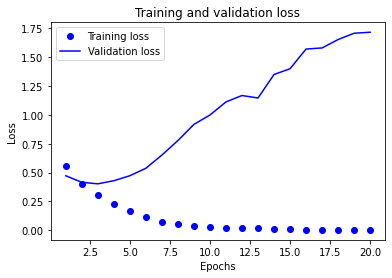

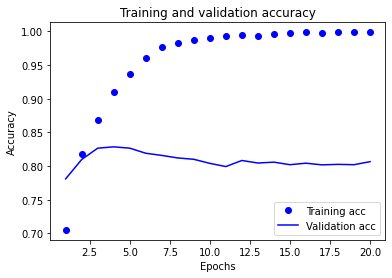

In [ ]:
# Plot Epoch Vs Accuracy & Epoch Vs Loss to assess the model performance

import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
print("The count of token words/frequency of their occurrence : ",tokenizer.word_counts)

The count of token words/frequency of their occurrence :  OrderedDict([('former', 106), ('versace', 1), ('store', 46), ('clerk', 9), ('sues', 17), ('secret', 90), ('black', 252), ('code', 18), ('minority', 15), ('shoppers', 3), ('roseanne', 3), ('revival', 11), ('catches', 14), ('thorny', 3), ('political', 83), ('mood', 13), ('better', 123), ('worse', 40), ('mom', 196), ('starting', 45), ('fear', 46), ('sons', 36), ('web', 19), ('series', 62), ('closest', 7), ('thing', 144), ('grandchild', 2), ('boehner', 27), ('wants', 138), ('wife', 77), ('listen', 24), ('come', 103), ('alternative', 11), ('debtreduction', 1), ('ideas', 42), ('jk', 7), ('rowling', 7), ('wishes', 42), ('snape', 2), ('happy', 62), ('birthday', 64), ('magical', 31), ('way', 248), ('advancing', 2), ('worlds', 92), ('women', 312), ('fascinating', 4), ('case', 94), ('eating', 66), ('labgrown', 1), ('meat', 25), ('ceo', 73), ('send', 34), ('kids', 196), ('school', 224), ('work', 178), ('company', 94), ('top', 123), ('snake'

In [ ]:
%%shell
jupyter nbconvert --to html /content/NLP_Project_2.ipynb

[NbConvertApp] Converting notebook /content/NLP_Project_2.ipynb to html
[NbConvertApp] Writing 3463766 bytes to /content/NLP_Project_2.html
